In [0]:
!pip install qiskit

     |████████████████████████████████| 6.7MB 7.2MB/s 
     |████████████████████████████████| 23.4MB 1.4MB/s 
     |████████████████████████████████| 163kB 48.0MB/s 
     |████████████████████████████████| 174kB 46.7MB/s 
     |████████████████████████████████| 1.9MB 41.1MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 5.6MB 40.4MB/s 
     |████████████████████████████████| 768kB 49.0MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 296kB 46.7MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 26.0MB 1.3MB/s 
     |████████████████████████████████| 573kB 42.3MB/s 
     |████████████████████████████████| 2.7MB 42.4MB/s 
  Created wheel for qiskit: filename=qiskit-0.19.2-cp36-none-any.whl size=2896 sha256=04e34546588077e5df71ddd76f05ebd82bb99b21c1c1c408f901af993188354e
  Stored in directory: /root/.cache/pip/wheels/d8/29/6e/e065f721b42fe704

In [0]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
'''def to_numbers(tensor_list):
    num_list = []

    for tensor in tensor_list:
      print('yo',tensor,end='\t')
      for j in range(len(tensor)):
        num_list+= [tensor[j].item()]
    print(num_list)
    return num_list
'''
def to_numbers(tensor_list):
    num_list = np.reshape(tensor_list.data.numpy(),-1)
    return num_list

In [0]:
class QiskitCircuit():
    def __init__(self,params,shots):
        self.params=params
        self.theta=[]
        for i in range(params):
          self.theta.append(Parameter('Theta'+str(i)))
        self.shots = shots
        
        def create_circuit():
            ckt = QuantumCircuit(1,1)
            #ckt.h(0)
            ckt.rx(self.theta[0],0)
            ckt.ry(self.theta[1],0)
            ckt.rz(self.theta[2],0)
            ckt.measure(0,0)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        self.theta = to_numbers(parameters)
        for i in range(3):
          self.circuit.data[i][0]._params = np.reshape(to_numbers(parameters)[i],(-1))
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

In [0]:
class TorchCircuit(Function):    
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(3,shots=100)
            
        exp_value = ctx.QiskitCirc.run(i) #[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2        #No reason for choosing such a big s.
        #Experimented with small s.  #Bad Idea
        
        forward_tensor, i = ctx.saved_tensors  
        
        input_numbers = to_numbers(i)  #[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s 
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))  #[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s 
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))  #[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

((100,), (100,))

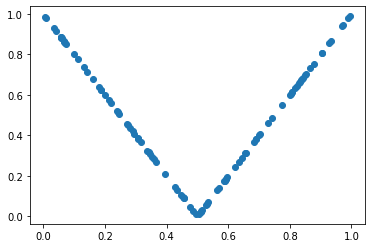

In [0]:
x_train = np.random.rand(100)
x_train = np.array(x_train, dtype=np.float32)

#y_train = x_train**2
y_train = 2*np.abs(x_train-0.5)
y_train = np.array(y_train, dtype=np.float32)

plt.scatter(x_train,y_train)
np.shape(x_train),np.shape(y_train)

In [0]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.h1 = nn.Linear(1, 5)
        self.h2 = nn.Linear(5, 3)

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  
        return x

In [0]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)
loss_list = []

In [52]:
epochs = 20
for epoch in range(epochs):
    total_loss = []
    for batch_idx in range(100):
        optimizer.zero_grad()
        target=torch.tensor(np.reshape(y_train[batch_idx],(1,1)),dtype=torch.double)
        data=torch.tensor(np.reshape(x_train[batch_idx],(1,1)),dtype=torch.float)
        output = network(data)

        loss = F.binary_cross_entropy(output,target) #F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(np.round(loss_list[-1],3),end=' ')

0.524 0.524 0.523 0.522 0.518 0.523 0.519 0.528 0.522 0.523 0.523 0.519 0.518 0.517 0.52 0.52 0.522 0.527 0.523 0.521 

Text(0, 0.5, 'Loss')

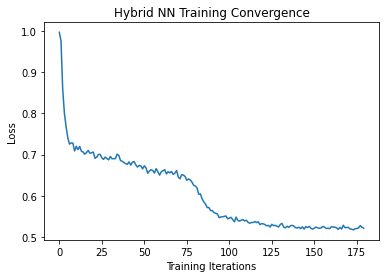

In [53]:
#hist=np.array(loss_list)
#plt.semilogy(hist-np.min(hist))
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

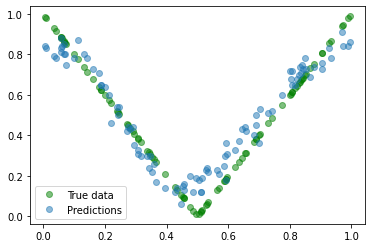

In [54]:
with torch.no_grad(): # we don't need gradients in the testing phase
    predicted_list = []
    for i in range(100):
      data=torch.tensor(np.reshape(x_train[i],(1,1)),dtype=torch.float)
      predicted = network(data).data.numpy()
      predicted_list.append(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, np.reshape(predicted_list,-1), 'o', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()